In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import pydicom
import matplotlib.pyplot as plt 

In [2]:
# upload train dataframe
train_df_allsamples = pd.read_csv("../data/marking.csv")
train_df_allsamples.head()

,patient_id,image_id,target,source,sex,age_approx,anatom_site_general_challenge
0,IP_7279968,ISIC_2637011,0,ISIC20,male,45.0,head/neck
1,IP_3075186,ISIC_0015719,0,ISIC20,female,45.0,upper extremity
2,IP_2842074,ISIC_0052212,0,ISIC20,female,50.0,lower extremity
3,IP_6890425,ISIC_0068279,0,ISIC20,female,45.0,head/neck
4,IP_8723313,ISIC_0074268,0,ISIC20,female,55.0,upper extremity


In [3]:
# create dictionary that maps image name to target 
image_names = train_df_allsamples["image_id"].values 
targets = train_df_allsamples["target"].values
img_to_target = {image_name:target for image_name, target in zip(image_names, targets)}

percent_tp = sum(targets)/len(targets) * 100 
print("{} training samples total.".format(len(targets)))
print("Only {:.3f} percent of training data set is a true positive.".format(percent_tp))
print("Therefore, the baseline accuracy is {:.3f}".format(np.max([percent_tp, 100-percent_tp])))

60487 training samples total.
Only 9.058 percent of training data set is a true positive.
Therefore, the baseline accuracy is 90.942


In [4]:
# update so that the number of positives balances negatives
train_df_pos = train_df_allsamples.iloc[targets>0, :]
train_df_neg = train_df_allsamples.iloc[targets==0, :]
train_df_negsample = train_df_neg.sample(n=int(train_df_pos.shape[0]))

# concatenate negative and positive samples, then shuffle using .sample() 
#train_val_df = pd.concat((train_df_pos, train_df_negsample)).sample(frac=1)
train_val_df = train_df_allsamples.sample(frac=1)

train_val_split = .99
n_train_val = train_val_df.shape[0]
n_train = int(train_val_split*n_train_val)

train_df = train_val_df[:n_train]
val_df = train_val_df[n_train:]

# create dictionary that maps image name to target 
image_names = val_df["image_id"].values 
val_targets = val_df["target"].values

percent_tp = sum(val_targets)/len(val_targets) * 100 
baseline = np.max([percent_tp, 100-percent_tp])

print("{} Training and {} Validation samples".format(n_train, n_train_val-n_train))
print("{:.3f} percent of validation data set is a positive.".format(percent_tp))
print("Baseline validation accuracy is {:.3f}".format(baseline))

59882 Training and 605 Validation samples
8.926 percent of validation data set is a positive.
Baseline validation accuracy is 91.074


image shape: 
(512, 512, 3)

 image is malignant?: 1


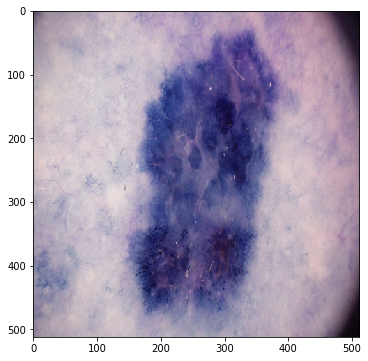

In [5]:
# start by trying to display an image from training set 

# specify path to training data  
train_path = "../data/512x512-dataset-melanoma/512x512-dataset-melanoma/"

# load all training files
train_files = [s+".jpg" for s in train_df["image_id"].values]

# pull an example 
img_ind = 0
example = train_path + train_files[img_ind]
img_name = train_files[img_ind].split(".")[0]
img = plt.imread(example)
print("image shape: ")
print(img.shape)
print("\n image is malignant?: {}".format(img_to_target[img_name]))

# display 
plt.figure(figsize=(9, 6))
plt.imshow(img)
plt.show()

Need image preprocessing steps to: 

1. Isolate the melanoma and crop image 
2. Ensure cropped images are a consistent size for input to CNN 

In [6]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from skimage.transform import resize

In [7]:
# Device configuration (GPU can be enabled in settings)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
print(device)

cuda:0


In [8]:
# set up data loader class 
def relative_scale(img, size=128, focus=1.5):
    # crop image (e.g. focus = 2 cuts image size in half)
    w, h = img[:, :, 0].shape 
    
    x_start = w//2 - np.int(w/(2*focus))
    x_end = w//2 + np.int(w/(2*focus))
    
    y_start = h//2 - np.int(h/(2*focus))
    y_end = h//2 + np.int(h/(2*focus))
    
    img_crop = img[x_start:x_end, y_start:y_end, :]
    
    img_resize = cv2.resize(img, (size, size))
    return img_resize

transform = transforms.Compose(
                   [transforms.RandomHorizontalFlip(p=0.5),
                    transforms.RandomVerticalFlip(p=0.5),
                    transforms.ToTensor()])
                    #transforms.Normalize(mean=[1., 1., 1.], std=[.5, .5, .5])])

class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, path_to_files):
        # 1. Initialize file paths or a list of file names.
        self.path = path_to_files
        self.df = df

    def __getitem__(self, index):
        # 1. Read one data from file (e.g. using numpy.fromfile, PIL.Image.open).
        
        # load X 
        img_name = self.df['image_id'].values[index]
        img_path = self.path + img_name + ".jpg"
        img = plt.imread(img_path)
        
        # load y 
        label = self.df["target"].values[index]
        target = torch.tensor(label, dtype=torch.float32)
        
        # 2. Preprocess the data (e.g. torchvision.Transform).
        img = Image.fromarray(img)
        #img = img.resize((256, 256))
        img_processed = transform(img)
        # 3. Return a data pair (e.g. image and label).
        return img_processed, target
        
    def __len__(self):
        # total size of your dataset.
        return self.df.shape[0]

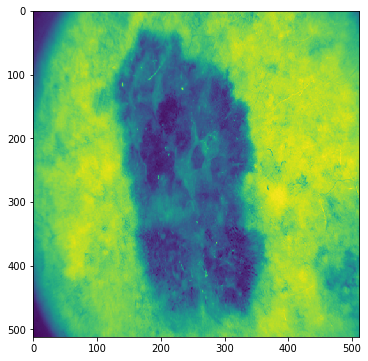

In [9]:
# Data loader (this provides queues and threads in a very simple way).
train_path = "../data/512x512-dataset-melanoma/512x512-dataset-melanoma/"
custom_dataset = Dataset(train_df, train_path)

train_loader = torch.utils.data.DataLoader(dataset=custom_dataset,
                                           batch_size=1,
                                           shuffle=False)

data_iter = iter(train_loader)

# Mini-batch images and labels.
images, labels = data_iter.next()

# lets look at the transformed image 
im = images[0, 0, :, :].numpy()
plt.figure(figsize=(9,6))
plt.imshow(im)
plt.show()

In [10]:
# Hyper parameters
num_epochs = 1
batch_size = 64
learning_rate = 0.005 

# Convolutional neural network
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=7, stride=2, padding=2),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4))
        self.layer2 = nn.Sequential(
            nn.Conv2d(8, 8, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4)) 
        self.fc = nn.Sequential(
            nn.Linear(1800, 32),
            nn.BatchNorm1d(32),
            nn.Sigmoid(),
            nn.Dropout(p=0.2))
        self.output = nn.Sequential(
            nn.Linear(32, 1),
            nn.Sigmoid())
        
    def embedding(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out 
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.output(out)
        return out

model = ConvNet().to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
def make_weights_for_balanced_classes(df, nclasses=2):   
    targets = df["target"].values
    count = [0] * nclasses                                                      
    for label in targets:                                                         
        count[label] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(targets)                                              
    for idx, label in enumerate(targets):                                          
        weight[idx] = weight_per_class[label]                                  
    return weight  

In [12]:
# Train the model
# Use the prebuilt data loader.
path = "../data/512x512-dataset-melanoma/512x512-dataset-melanoma/"

train_dataset = Dataset(train_df, path)
train_weights = make_weights_for_balanced_classes(train_df)
train_sampler = torch.utils.data.sampler.WeightedRandomSampler(train_weights, len(train_weights))                                                
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           sampler = train_sampler)   

# evaluate performance on validation data 
valid_dataset = Dataset(val_df, path)
valid_weights = make_weights_for_balanced_classes(val_df)
valid_sampler = torch.utils.data.sampler.WeightedRandomSampler(valid_weights, len(valid_weights))                                                
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, 
                                           batch_size=50, 
                                           sampler = valid_sampler) 

# save losses from training 
losses = []
val_acc = []

total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # set up model for training 
        model = model.train()
        
        images = images.to(device)
        
        labels = torch.reshape(labels, [len(labels), 1])
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Calculate accuracy
        predicted = torch.round(outputs)
        correct_train = predicted.eq(labels).sum().item()
        train_accuracy = 100 * correct_train / len(labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # store loss
        losses.append(loss)
        
        #stop
        
        # prep model for evaluation
        model.eval() 
        correct_val=0
        for j, (images, labels) in enumerate(valid_loader):
            images = images.to(device)

            labels = torch.reshape(labels, [len(labels), 1])
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)

            # Calculate accuracy
            predicted = torch.round(outputs)
            correct_val += predicted.eq(labels).sum().item()
        val_accuracy = 100 * correct_val / val_df.shape[0]
        val_acc.append(val_accuracy)
        
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Train Acc: {:.4f}, Val Acc: {:.4f}' 
               .format(epoch+1, num_epochs, i+1, total_step, loss.item(), train_accuracy, val_accuracy))

Epoch [1/1], Step [1/936], Loss: 0.7008, Train Acc: 43.7500, Val Acc: 49.5868
Epoch [1/1], Step [2/936], Loss: 0.8463, Train Acc: 43.7500, Val Acc: 56.3636
Epoch [1/1], Step [3/936], Loss: 0.7306, Train Acc: 53.1250, Val Acc: 52.5620
Epoch [1/1], Step [4/936], Loss: 0.6276, Train Acc: 70.3125, Val Acc: 52.3967
Epoch [1/1], Step [5/936], Loss: 0.5934, Train Acc: 70.3125, Val Acc: 54.3802
Epoch [1/1], Step [6/936], Loss: 0.5784, Train Acc: 73.4375, Val Acc: 64.4628
Epoch [1/1], Step [7/936], Loss: 0.6429, Train Acc: 62.5000, Val Acc: 56.8595
Epoch [1/1], Step [8/936], Loss: 0.5929, Train Acc: 71.8750, Val Acc: 52.5620
Epoch [1/1], Step [9/936], Loss: 0.6010, Train Acc: 73.4375, Val Acc: 60.8264
Epoch [1/1], Step [10/936], Loss: 0.6186, Train Acc: 65.6250, Val Acc: 69.2562
Epoch [1/1], Step [11/936], Loss: 0.6418, Train Acc: 67.1875, Val Acc: 65.1240
Epoch [1/1], Step [12/936], Loss: 0.5424, Train Acc: 76.5625, Val Acc: 66.4463
Epoch [1/1], Step [13/936], Loss: 0.5859, Train Acc: 71.8750,

Epoch [1/1], Step [105/936], Loss: 0.6728, Train Acc: 59.3750, Val Acc: 68.4298
Epoch [1/1], Step [106/936], Loss: 0.5231, Train Acc: 75.0000, Val Acc: 71.9008
Epoch [1/1], Step [107/936], Loss: 0.5117, Train Acc: 76.5625, Val Acc: 74.7107
Epoch [1/1], Step [108/936], Loss: 0.5794, Train Acc: 70.3125, Val Acc: 68.4298
Epoch [1/1], Step [109/936], Loss: 0.4855, Train Acc: 78.1250, Val Acc: 72.2314
Epoch [1/1], Step [110/936], Loss: 0.5305, Train Acc: 78.1250, Val Acc: 72.5620
Epoch [1/1], Step [111/936], Loss: 0.5597, Train Acc: 65.6250, Val Acc: 71.4050
Epoch [1/1], Step [112/936], Loss: 0.5566, Train Acc: 67.1875, Val Acc: 70.2479
Epoch [1/1], Step [113/936], Loss: 0.5845, Train Acc: 68.7500, Val Acc: 71.7355
Epoch [1/1], Step [114/936], Loss: 0.5213, Train Acc: 76.5625, Val Acc: 69.5868
Epoch [1/1], Step [115/936], Loss: 0.4585, Train Acc: 79.6875, Val Acc: 70.0826
Epoch [1/1], Step [116/936], Loss: 0.5854, Train Acc: 67.1875, Val Acc: 75.3719
Epoch [1/1], Step [117/936], Loss: 0.611

Epoch [1/1], Step [208/936], Loss: 0.5150, Train Acc: 76.5625, Val Acc: 79.1736
Epoch [1/1], Step [209/936], Loss: 0.4728, Train Acc: 75.0000, Val Acc: 74.2149
Epoch [1/1], Step [210/936], Loss: 0.4651, Train Acc: 79.6875, Val Acc: 75.8678
Epoch [1/1], Step [211/936], Loss: 0.5270, Train Acc: 75.0000, Val Acc: 78.3471
Epoch [1/1], Step [212/936], Loss: 0.4240, Train Acc: 87.5000, Val Acc: 76.6942
Epoch [1/1], Step [213/936], Loss: 0.5435, Train Acc: 73.4375, Val Acc: 74.8760
Epoch [1/1], Step [214/936], Loss: 0.4201, Train Acc: 79.6875, Val Acc: 73.0579
Epoch [1/1], Step [215/936], Loss: 0.5552, Train Acc: 71.8750, Val Acc: 74.0496
Epoch [1/1], Step [216/936], Loss: 0.5178, Train Acc: 81.2500, Val Acc: 71.2397
Epoch [1/1], Step [217/936], Loss: 0.6176, Train Acc: 70.3125, Val Acc: 74.0496
Epoch [1/1], Step [218/936], Loss: 0.4787, Train Acc: 76.5625, Val Acc: 69.7521
Epoch [1/1], Step [219/936], Loss: 0.5701, Train Acc: 75.0000, Val Acc: 76.8595
Epoch [1/1], Step [220/936], Loss: 0.609

Epoch [1/1], Step [311/936], Loss: 0.5856, Train Acc: 70.3125, Val Acc: 74.5455
Epoch [1/1], Step [312/936], Loss: 0.4956, Train Acc: 76.5625, Val Acc: 72.2314
Epoch [1/1], Step [313/936], Loss: 0.4883, Train Acc: 75.0000, Val Acc: 73.5537
Epoch [1/1], Step [314/936], Loss: 0.5050, Train Acc: 71.8750, Val Acc: 71.4050
Epoch [1/1], Step [315/936], Loss: 0.4812, Train Acc: 73.4375, Val Acc: 72.3967
Epoch [1/1], Step [316/936], Loss: 0.4509, Train Acc: 76.5625, Val Acc: 73.2231
Epoch [1/1], Step [317/936], Loss: 0.5604, Train Acc: 76.5625, Val Acc: 69.0909
Epoch [1/1], Step [318/936], Loss: 0.5769, Train Acc: 62.5000, Val Acc: 70.5785
Epoch [1/1], Step [319/936], Loss: 0.5700, Train Acc: 71.8750, Val Acc: 67.4380
Epoch [1/1], Step [320/936], Loss: 0.5022, Train Acc: 75.0000, Val Acc: 71.4050
Epoch [1/1], Step [321/936], Loss: 0.5473, Train Acc: 73.4375, Val Acc: 68.4298
Epoch [1/1], Step [322/936], Loss: 0.4232, Train Acc: 85.9375, Val Acc: 65.4545
Epoch [1/1], Step [323/936], Loss: 0.416

Epoch [1/1], Step [414/936], Loss: 0.5302, Train Acc: 79.6875, Val Acc: 75.0413
Epoch [1/1], Step [415/936], Loss: 0.4631, Train Acc: 79.6875, Val Acc: 73.7190
Epoch [1/1], Step [416/936], Loss: 0.3985, Train Acc: 82.8125, Val Acc: 73.3884
Epoch [1/1], Step [417/936], Loss: 0.5012, Train Acc: 75.0000, Val Acc: 71.5702
Epoch [1/1], Step [418/936], Loss: 0.6770, Train Acc: 64.0625, Val Acc: 74.5455
Epoch [1/1], Step [419/936], Loss: 0.5097, Train Acc: 71.8750, Val Acc: 74.7107
Epoch [1/1], Step [420/936], Loss: 0.5072, Train Acc: 75.0000, Val Acc: 73.0579
Epoch [1/1], Step [421/936], Loss: 0.3986, Train Acc: 82.8125, Val Acc: 74.0496
Epoch [1/1], Step [422/936], Loss: 0.4629, Train Acc: 76.5625, Val Acc: 74.0496
Epoch [1/1], Step [423/936], Loss: 0.4768, Train Acc: 76.5625, Val Acc: 71.7355
Epoch [1/1], Step [424/936], Loss: 0.5739, Train Acc: 68.7500, Val Acc: 70.5785
Epoch [1/1], Step [425/936], Loss: 0.5343, Train Acc: 73.4375, Val Acc: 69.5868
Epoch [1/1], Step [426/936], Loss: 0.442

Epoch [1/1], Step [517/936], Loss: 0.5031, Train Acc: 73.4375, Val Acc: 77.5207
Epoch [1/1], Step [518/936], Loss: 0.4161, Train Acc: 82.8125, Val Acc: 79.8347
Epoch [1/1], Step [519/936], Loss: 0.4752, Train Acc: 73.4375, Val Acc: 75.0413
Epoch [1/1], Step [520/936], Loss: 0.4896, Train Acc: 78.1250, Val Acc: 74.5455
Epoch [1/1], Step [521/936], Loss: 0.5486, Train Acc: 65.6250, Val Acc: 77.0248
Epoch [1/1], Step [522/936], Loss: 0.5254, Train Acc: 68.7500, Val Acc: 80.8264
Epoch [1/1], Step [523/936], Loss: 0.5926, Train Acc: 73.4375, Val Acc: 80.1653
Epoch [1/1], Step [524/936], Loss: 0.4358, Train Acc: 82.8125, Val Acc: 77.8512
Epoch [1/1], Step [525/936], Loss: 0.4809, Train Acc: 75.0000, Val Acc: 76.1983
Epoch [1/1], Step [526/936], Loss: 0.4841, Train Acc: 76.5625, Val Acc: 74.5455
Epoch [1/1], Step [527/936], Loss: 0.4293, Train Acc: 81.2500, Val Acc: 74.2149
Epoch [1/1], Step [528/936], Loss: 0.5219, Train Acc: 75.0000, Val Acc: 77.6860
Epoch [1/1], Step [529/936], Loss: 0.528

Epoch [1/1], Step [620/936], Loss: 0.4946, Train Acc: 78.1250, Val Acc: 70.4132
Epoch [1/1], Step [621/936], Loss: 0.6012, Train Acc: 67.1875, Val Acc: 71.5702
Epoch [1/1], Step [622/936], Loss: 0.5320, Train Acc: 67.1875, Val Acc: 69.7521
Epoch [1/1], Step [623/936], Loss: 0.4229, Train Acc: 81.2500, Val Acc: 67.6033
Epoch [1/1], Step [624/936], Loss: 0.4749, Train Acc: 73.4375, Val Acc: 73.0579
Epoch [1/1], Step [625/936], Loss: 0.5126, Train Acc: 73.4375, Val Acc: 72.7273
Epoch [1/1], Step [626/936], Loss: 0.5246, Train Acc: 76.5625, Val Acc: 70.5785
Epoch [1/1], Step [627/936], Loss: 0.4839, Train Acc: 79.6875, Val Acc: 72.0661
Epoch [1/1], Step [628/936], Loss: 0.3989, Train Acc: 81.2500, Val Acc: 73.8843
Epoch [1/1], Step [629/936], Loss: 0.5385, Train Acc: 71.8750, Val Acc: 70.0826
Epoch [1/1], Step [630/936], Loss: 0.5222, Train Acc: 75.0000, Val Acc: 72.5620
Epoch [1/1], Step [631/936], Loss: 0.5826, Train Acc: 70.3125, Val Acc: 71.2397
Epoch [1/1], Step [632/936], Loss: 0.463

Epoch [1/1], Step [723/936], Loss: 0.5345, Train Acc: 71.8750, Val Acc: 71.0744
Epoch [1/1], Step [724/936], Loss: 0.4741, Train Acc: 71.8750, Val Acc: 70.4132
Epoch [1/1], Step [725/936], Loss: 0.4055, Train Acc: 79.6875, Val Acc: 73.5537
Epoch [1/1], Step [726/936], Loss: 0.4669, Train Acc: 78.1250, Val Acc: 72.3967
Epoch [1/1], Step [727/936], Loss: 0.5197, Train Acc: 70.3125, Val Acc: 76.3636
Epoch [1/1], Step [728/936], Loss: 0.5538, Train Acc: 76.5625, Val Acc: 72.5620
Epoch [1/1], Step [729/936], Loss: 0.5711, Train Acc: 65.6250, Val Acc: 68.2645
Epoch [1/1], Step [730/936], Loss: 0.5541, Train Acc: 70.3125, Val Acc: 70.2479
Epoch [1/1], Step [731/936], Loss: 0.5572, Train Acc: 71.8750, Val Acc: 72.0661
Epoch [1/1], Step [732/936], Loss: 0.4777, Train Acc: 76.5625, Val Acc: 70.5785
Epoch [1/1], Step [733/936], Loss: 0.5395, Train Acc: 70.3125, Val Acc: 68.5950
Epoch [1/1], Step [734/936], Loss: 0.5591, Train Acc: 68.7500, Val Acc: 66.1157
Epoch [1/1], Step [735/936], Loss: 0.488

Epoch [1/1], Step [826/936], Loss: 0.4742, Train Acc: 73.4375, Val Acc: 71.5702
Epoch [1/1], Step [827/936], Loss: 0.5306, Train Acc: 71.8750, Val Acc: 68.0992
Epoch [1/1], Step [828/936], Loss: 0.5017, Train Acc: 73.4375, Val Acc: 69.9174
Epoch [1/1], Step [829/936], Loss: 0.5094, Train Acc: 78.1250, Val Acc: 76.8595
Epoch [1/1], Step [830/936], Loss: 0.4221, Train Acc: 82.8125, Val Acc: 72.0661
Epoch [1/1], Step [831/936], Loss: 0.4863, Train Acc: 73.4375, Val Acc: 75.7025
Epoch [1/1], Step [832/936], Loss: 0.5500, Train Acc: 73.4375, Val Acc: 72.7273
Epoch [1/1], Step [833/936], Loss: 0.4579, Train Acc: 73.4375, Val Acc: 72.5620
Epoch [1/1], Step [834/936], Loss: 0.4935, Train Acc: 76.5625, Val Acc: 70.7438
Epoch [1/1], Step [835/936], Loss: 0.4745, Train Acc: 73.4375, Val Acc: 69.4215
Epoch [1/1], Step [836/936], Loss: 0.5313, Train Acc: 75.0000, Val Acc: 71.5702
Epoch [1/1], Step [837/936], Loss: 0.5196, Train Acc: 76.5625, Val Acc: 74.5455
Epoch [1/1], Step [838/936], Loss: 0.455

Epoch [1/1], Step [929/936], Loss: 0.4634, Train Acc: 71.8750, Val Acc: 77.6860
Epoch [1/1], Step [930/936], Loss: 0.6304, Train Acc: 68.7500, Val Acc: 77.6860
Epoch [1/1], Step [931/936], Loss: 0.4795, Train Acc: 76.5625, Val Acc: 78.3471
Epoch [1/1], Step [932/936], Loss: 0.4834, Train Acc: 75.0000, Val Acc: 77.8512
Epoch [1/1], Step [933/936], Loss: 0.3988, Train Acc: 81.2500, Val Acc: 77.1901
Epoch [1/1], Step [934/936], Loss: 0.4077, Train Acc: 85.9375, Val Acc: 79.0083
Epoch [1/1], Step [935/936], Loss: 0.4240, Train Acc: 78.1250, Val Acc: 79.6694
Epoch [1/1], Step [936/936], Loss: 0.5664, Train Acc: 66.6667, Val Acc: 75.5372


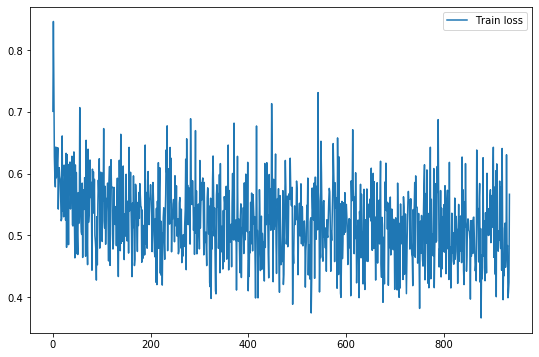

In [13]:
plt.figure(figsize=(9,6))
plt.plot(losses,label='Train loss')
#plt.ylim([.4, .8])
plt.legend()
plt.show()

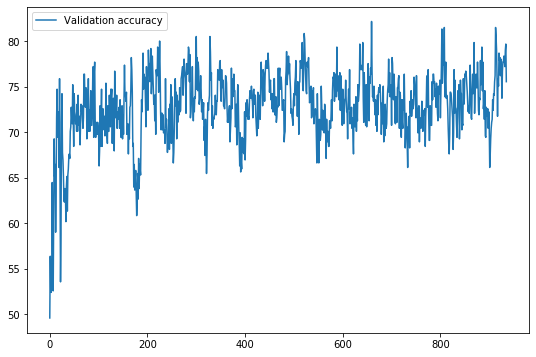

In [14]:
plt.figure(figsize=(9,6))
plt.plot(val_acc,label='Validation accuracy')
plt.legend()
plt.show()


Baseline classification accuracy: 91.07

Model classification accuracy:    0.65


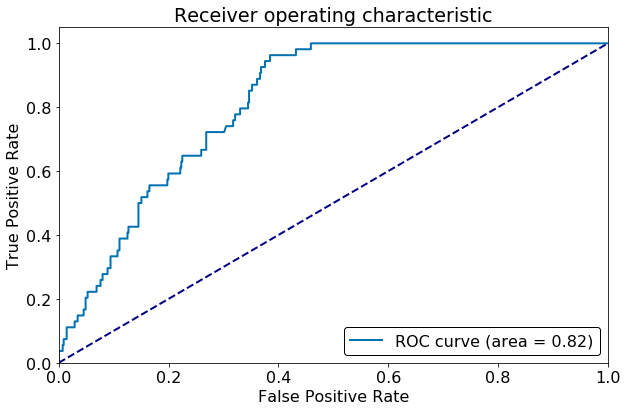

In [15]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

valid_predictions = []
valid_targets = []

valid_dataset = Dataset(val_df, path)                                             
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, 
                                           batch_size=50, 
                                           shuffle=False) 

model.eval() # prep model for evaluation
with torch.no_grad():
    for i, (images, labels) in enumerate(valid_loader):
        images = images.to(device)

        labels = torch.reshape(labels, [len(labels), 1])
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        valid_predictions += list(outputs.detach().cpu().numpy().ravel())
        valid_targets += list(labels.cpu().numpy().ravel()) 

fpr, tpr, _ = roc_curve(np.array(valid_targets, np.int), np.array(valid_predictions).ravel())
roc_auc = auc(fpr, tpr)

percent_tp = sum(valid_targets)/len(valid_targets) * 100 
baseline = np.max([percent_tp, 100-percent_tp])
acc = np.sum(np.round(valid_predictions) == np.array(valid_targets)) / len(valid_targets)

print('\nBaseline classification accuracy: {:.2f}'.format(baseline))
print('\nModel classification accuracy:    {:.2f}'.format(acc))

plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 16, 
                     'legend.framealpha':1, 
                     'legend.edgecolor':'inherit'}) 
plt.figure(figsize=(9, 6))

lw = 2
plt.plot(fpr, tpr, 
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

In [ ]:
confusion_matrix(np.array(valid_targets, np.int), np.round(np.array(valid_predictions).ravel()))

In [17]:
# Save  the entire model.
train_df.to_csv("train_df.csv", index=False)
val_df.to_csv("val_df.csv", index=False)

torch.save(model.state_dict(), 'model.ckpt')